In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in data
ue = pd.read_csv('takehome_user_engagement.csv')
user = pd.read_csv('takehome_users.csv',encoding = "latin")

In [3]:
ue['time_stamp'] = pd.to_datetime(ue['time_stamp'])

In [4]:
d = ue.drop_duplicates(subset='time_stamp')

In [5]:
d['date'] = d['time_stamp'].dt.date

C:\Users\pseudo_bounce\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
d = d.sort_values(by='date')

In [7]:
pivot = d.pivot_table(index='user_id',columns='date',values='visited')

In [8]:
v = pivot.reset_index()

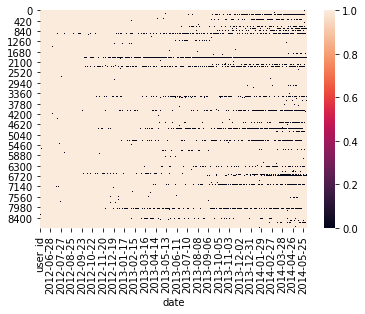

In [9]:
sns.heatmap(v.isnull())

In [10]:
vtranspose = v.T

In [12]:
w = vtranspose.drop('user_id')

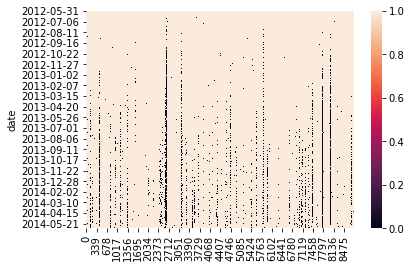

In [13]:
sns.heatmap(w.isnull())

In [14]:
w = w.fillna(0)

In [15]:
#determining adopted users
adopted_users = []
for col in w.columns:
    if sum(w[col].rolling(7).sum() >= 3):
        adopted_users.append(col)

In [16]:
print(f'Number of total users is {ue["user_id"].nunique()}')
print(f'Number of adopted users is {len(adopted_users)}')
print(f'Percentage of adopted users is {round((len(adopted_users) / ue["user_id"].nunique())*100,3)}%')

Number of total users is 8823
Number of adopted users is 1601
Percentage of adopted users is 18.146%


In [17]:
#create dataframe from adopted users list
adopted = pd.DataFrame()
adopted['object_id'] = adopted_users
adopted['indicator'] = 1

In [18]:
#merge adopters users df to users df
df = user.merge(adopted, on = 'object_id',how='outer')

#Fill null values with 0
df['indicator'].fillna(0,inplace=True)

In [19]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,indicator
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [20]:
df['indicator'].value_counts()

0.0    10399
1.0     1601
Name: indicator, dtype: int64

In [21]:
df.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
indicator                        0
dtype: int64

In [22]:
#last_session_creation_time is encoded as a float, convert to datetime
df['last_session_time'] = pd.to_datetime(df['last_session_creation_time'])
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [23]:
df['creation_time'].sort_values()

3860    2012-05-31 00:43:27
11429   2012-05-31 01:42:31
7169    2012-05-31 06:23:51
10011   2012-05-31 08:20:06
11998   2012-05-31 11:55:59
                ...        
6944    2014-05-30 23:10:35
9687    2014-05-30 23:12:01
10163   2014-05-30 23:27:30
3489    2014-05-30 23:45:01
6052    2014-05-30 23:59:19
Name: creation_time, Length: 12000, dtype: datetime64[ns]

In [24]:
df['last_session_time'].sort_values()

10011   1970-01-01 00:00:01.338452406
9898    1970-01-01 00:00:01.338484777
11429   1970-01-01 00:00:01.338514951
1994    1970-01-01 00:00:01.338556458
10162   1970-01-01 00:00:01.338561038
                     ...             
11975                             NaT
11977                             NaT
11984                             NaT
11992                             NaT
11993                             NaT
Name: last_session_time, Length: 12000, dtype: datetime64[ns]

In [25]:
df['last_session_time'].head()

0   1970-01-01 00:00:01.398138810
1   1970-01-01 00:00:01.396237504
2   1970-01-01 00:00:01.363734892
3   1970-01-01 00:00:01.369210168
4   1970-01-01 00:00:01.358849660
Name: last_session_time, dtype: datetime64[ns]

In [26]:
df['last_session_time'].tail()

11995   1970-01-01 00:00:01.378448055
11996   1970-01-01 00:00:01.358274517
11997   1970-01-01 00:00:01.398602716
11998   1970-01-01 00:00:01.338638159
11999   1970-01-01 00:00:01.390726632
Name: last_session_time, dtype: datetime64[ns]

The last session creation time is determined to be invalid as all of the dates are from 1970.  This is assumed to be a data quality issue.  As such, using this variable would not make sense as the dates are incorrect.

In [27]:
#drop last session time, last ession creation time
df.drop(['last_session_time','last_session_creation_time'],axis=1,inplace=True)

In [28]:
#create a variable that captures the account age, with latest date as 'current'
df['last_day'] = '2014-05-30'
df['last_day'] = pd.to_datetime(df['last_day'])

#obtain account age
df['account_age'] = df['last_day'] - df['creation_time']

#grab the number of days from the timestamp
df['account_age'] = df['account_age'].dt.days

In [29]:
#convert invited by user to category tyoe
df['invited_by_user_id'] = df['invited_by_user_id'].astype('category')
df['invited_by_user_id'] = df['invited_by_user_id'].cat.codes

In [30]:
#convert invited by user to category tyoe
df['org_id'] = df['org_id'].astype('category')
df['org_id'] = df['org_id'].cat.codes

In [31]:
df['email_type'] = df['email'].apply(lambda x: x.split('@')[1])

In [32]:
df['email_type'].value_counts(normalize=True)

gmail.com         0.296833
yahoo.com         0.203917
jourrapide.com    0.104917
cuvox.de          0.100167
gustr.com         0.098250
                    ...   
hufog.com         0.000083
ncwdw.com         0.000083
skuvv.com         0.000083
uddig.com         0.000083
xeeia.com         0.000083
Name: email_type, Length: 1184, dtype: float64

In [33]:
temp = df[df['email_type'].map(df['email_type'].value_counts(normalize=True)) > 0.09]

In [34]:
df['email_type'] = np.where(df['email_type'].isin(temp['email_type']),df['email_type'],'rare')

In [35]:
df['email_type'].value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
rare              1186
gustr.com         1179
hotmail.com       1165
Name: email_type, dtype: int64

In [36]:
df.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,indicator,last_day,account_age,email_type
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,2324,1.0,2014-05-30,37,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,55,0.0,2014-05-30,195,gustr.com
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,297,0.0,2014-05-30,436,gustr.com
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,1103,0.0,2014-05-30,373,yahoo.com
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,1126,0.0,2014-05-30,497,yahoo.com


In [38]:
#Categorical encoding on the creation source column
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
cs_encode = ohe.fit_transform(df.creation_source.values.reshape(-1,1)).toarray()
df_hot = pd.DataFrame(cs_encode,columns=['cs_1','cs_2','cs_3','cs_4','cs_5'])
df_encode =pd.concat([df, df_hot], axis=1)


In [39]:
email_encode = ohe.fit_transform(df_encode['email_type'].values.reshape(-1,1)).toarray()
df_hot_email = pd.DataFrame(email_encode,columns = ['em1','em2','em3','em4','em5','em6','em7'])
df_final = pd.concat([df_encode,df_hot_email],axis=1)
df_final.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,indicator,...,cs_3,cs_4,cs_5,em1,em2,em3,em4,em5,em6,em7
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,2324,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,55,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,297,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,1103,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,1126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


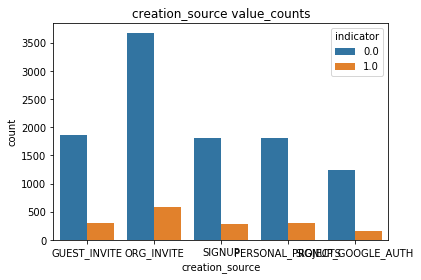

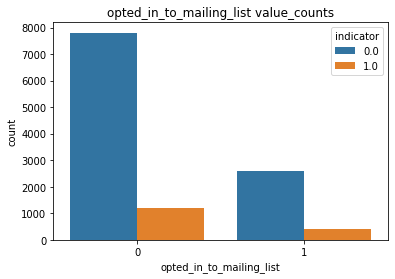

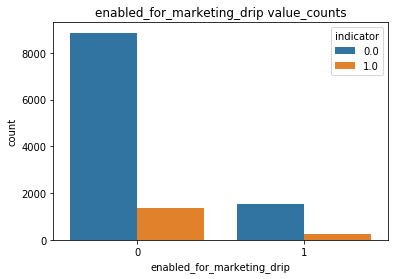

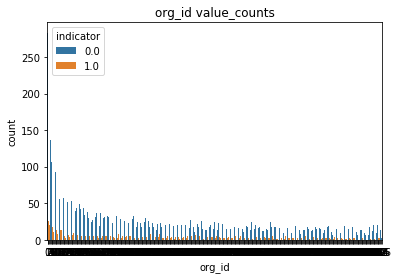

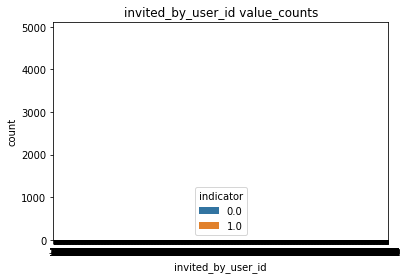

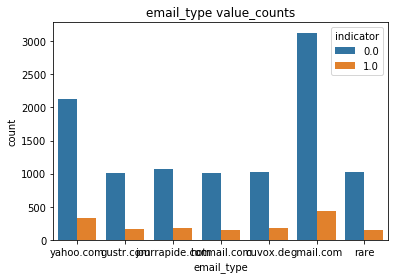

In [40]:
cols = ['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id','email_type']
for col in cols:
    sns.countplot(x=col, data=df_final, hue='indicator')
    plt.title(f"{col} value_counts")
    plt.ylabel('count')
    plt.show()

Text(0.5, 1.0, 'Target Column Distribution')

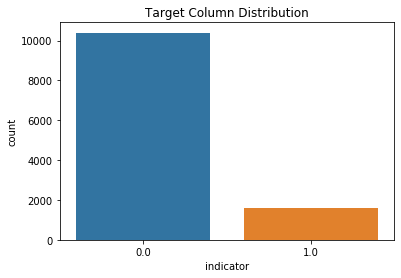

In [41]:
sns.countplot(df_final['indicator'])
plt.title('Target Column Distribution')

The value count plots of the categorical variables do not seem to show anything interesting.  A preliminary model that used the creation source and email type did not add any value to the model.  As such, these features are removed from the model.  The only features kept for the model are 'opted_in_to_mailing_list','enabled_for_marketing_drip','account_age'

In [42]:
cols_to_keep = ['opted_in_to_mailing_list','enabled_for_marketing_drip','account_age']

In [43]:
X = df_final[cols_to_keep]
y = df_final['indicator']

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, auc,roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [45]:
#create train and test sets, and stratify the target column
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=1618,stratify=y)

In [46]:
# use random forest model with balanced class weights to correct for imbalance in the data
clf = RandomForestClassifier(random_state=42)
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params,scoring='roc_auc')
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('roc_auc score', model.best_score_)

Best parameters were {'n_estimators': 100}
roc_auc score 0.49928212208343004


In [47]:
# store predictions
y_preds = model.best_estimator_.predict(X_test)

#get classification report, convert to dataframe
report = classification_report(y_test,y_preds,output_dict=True)
report_rf = pd.DataFrame(report).transpose()
report_rf

,precision,recall,f1-score,support
0.0,0.868184,0.972115,0.917215,2080.000000
1.0,0.183099,0.040625,0.066496,320.000000
accuracy,0.847917,0.847917,0.847917,0.847917
macro avg,0.525641,0.506370,0.491855,2400.000000
weighted avg,0.776839,0.847917,0.803786,2400.000000


In [48]:
confusion_matrix(y_test,y_preds)

array([[2022,   58],
       [ 307,   13]], dtype=int64)

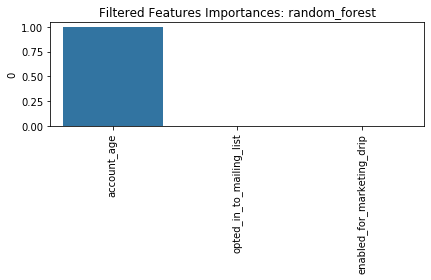

In [49]:
fi = model.best_estimator_.feature_importances_
df_imp = pd.DataFrame(data=fi,index=X_train.columns).sort_values(by=0,ascending=False)
sns.barplot(x=df_imp.index,y=df_imp[0])
plt.title("Filtered Features Importances: random_forest")
plt.xticks(rotation=90)
plt.tight_layout()

In [50]:
accuracy_score(y_preds,y_test)

0.8479166666666667

Given the large class imbalance in the target class, we can try to improve the model by applying upsampling to create synthetic data points.

In [51]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)

In [52]:
# use random forest model with balanced class weights to correct for imbalance in the data
clf = RandomForestClassifier(random_state=42)
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params,scoring='roc_auc')
model.fit(X_resampled, y_resampled)
print('Best parameters were', model.best_params_)
print('roc_auc score', model.best_score_)

Best parameters were {'n_estimators': 200}
roc_auc score 0.671731241071085


In [53]:
# store predictions
y_preds = model.best_estimator_.predict(X_test)

#get classification report, convert to dataframe
report = classification_report(y_test,y_preds,output_dict=True)
report_rf = pd.DataFrame(report).transpose()
report_rf

,precision,recall,f1-score,support
0.0,0.855830,0.582212,0.692990,2080.000000
1.0,0.117766,0.362500,0.177778,320.000000
accuracy,0.552917,0.552917,0.552917,0.552917
macro avg,0.486798,0.472356,0.435384,2400.000000
weighted avg,0.757422,0.552917,0.624295,2400.000000


In [54]:
confusion_matrix(y_test,y_preds)

array([[1211,  869],
       [ 204,  116]], dtype=int64)

  Overall the model performs poorly as the variables used do not capture the relationshp with the targer variable well.  Applying the resampling technique gave an improvement in auc score of about 17%, but that still leaves an auc score of 67%.  The most explanatory variable was the account age.  A more explanatory variable could be created by using the last_session_creation_time along with the creation date to calculate the time elasped since last use.  However, the last_session_creation_time feature is unusable as the dates are determined to be invalid.  The most important feature in this case is the history, as it is the only variable with a time component.  The other feaures, opted_into_mailing_list and 'enabled_for_marketing_drip' do not provide any value.  At the outset I thought that these variables would provide value as the input is provided by the user, but it seems the most explanatory variables are those with a time component.

To improve the model it is recommended that the correct values 'last_session_creation_time' feature are obtained so it could be used to engineer better features. In all categories of the creation source, users adopting the app is low. This is expected as the adopted users only account for roughly 18% of the cohort.  In order to increase user adoption, the recommendation would be to redesign and include new features to the app.  With such low engagement it is apparent that the app is only useful to a handful of people.  This is supported by the fact the opting in for mailing list and enabling marketing drip does not provide any value in the sense of getting users to adopt. 
